In [1]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
#pd.set_option('display.max_rows', 200)
pd.set_option("display.max_columns", 999)
import uproot
import os
from multiprocessing import Pool
import psutil

import tensorflow as tf
print(tf.__version__)
print(tf.test.is_built_with_cuda())

2023-07-31 16:57:28.508754: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-31 16:57:28.717695: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.10.0
True


In [2]:
def get_min(Ref, Array):
    return np.argmin(np.abs(Ref - Array))

In [3]:
def add_more_cols(DF):
    DF["P1M"] = (DF["Mjj_msortedP1_high"] + DF["Mjj_msortedP1_low"]) / 2
    DF["P2M"] = (DF["Mjj_msortedP2_high"] + DF["Mjj_msortedP2_low"]) / 2
    DF["P3M"] = (DF["Mjj_msortedP3_high"] + DF["Mjj_msortedP3_low"]) / 2
    
    DF["dRi"] = DF.apply(lambda row: get_min(row["Mjj_avg_dRpairing_GeV"], 
                                np.array([row["P1M"], row["P2M"], row["P3M"]])), axis = 1)
    DF["Truth_high"] = DF.apply(lambda row: get_min(row["Mass"], np.array([row["Mjj_msortedP1_high"], 
                                row["Mjj_msortedP2_high"], row["Mjj_msortedP3_high"]])), axis = 1)
    DF["Truth_avg"] = DF.apply(lambda row: get_min(row["Mass"], 
                                np.array([row["P1M"], row["P2M"], row["P3M"]])), axis = 1)
    
    DF["P1QSMD"] = (DF["Mjj_msortedP1_high"] - DF["Mass"])**2 + (DF["Mjj_msortedP1_low"] - DF["Mass"])**2
    DF["P2QSMD"] = (DF["Mjj_msortedP2_high"] - DF["Mass"])**2 + (DF["Mjj_msortedP2_low"] - DF["Mass"])**2
    DF["P3QSMD"] = (DF["Mjj_msortedP3_high"] - DF["Mass"])**2 + (DF["Mjj_msortedP3_low"] - DF["Mass"])**2
    
    DF["Truth_QSMD"] = DF.apply(lambda row: get_min(0, 
                                np.array([row["P1QSMD"], row["P2QSMD"], row["P3QSMD"]])), axis = 1)

In [4]:
def normalize_inouts(DF):
    GevCols = ["Mjj_msortedP1_high", "Mjj_msortedP1_low", "Mjj_msortedP2_high", "Mjj_msortedP2_low", 
               "Mjj_msortedP3_high", "Mjj_msortedP3_low", "Mjj_avg_dRpairing_GeV",
               "pt_ordered_jet1_pt", "pt_ordered_jet2_pt", "pt_ordered_jet3_pt", "pt_ordered_jet4_pt"]
    for GevCol in GevCols:
        DF[GevCol] = DF[GevCol] / 1000
    
    OtherCols = ["pt_ordered_jet" + str(i) + "_m" for i in range(1,5)]
    for OtherCol in OtherCols:
        DF[OtherCol] = DF[OtherCol] / 100
    
    return DF

In [5]:
def make_training_and_testing_pd(Mass):
    TrainingRows = 100000
    TestingRows = 50000
    File = "ML_TTree/tree_ML_MCRun2_" + str(Mass) + "GeV.root"
    
    print("Processing file: " + File + "\n")
    Events = uproot.open(File)["tree_ML"]
    DF = Events.arrays(library="pd")
    DF = DF.loc[DF["evt_trig"] == 1].reset_index(drop=True)
    DF["Mass"] = Mass
    add_more_cols(DF)
    normalize_inouts(DF)
    
    TrainingDF = DF.loc[0:TrainingRows-1]
    TestingDF = DF.loc[TrainingRows:TrainingRows+TestingRows-1]
    
    return [TrainingDF, TestingDF]

In [6]:
Masses = [500, 600, 700, 800, 900, 1000]

In [7]:
#multithreading and memory monitoring in case large input files in the future
Mem0 = psutil.virtual_memory().available

TrainingDF = None
TestingDF = None
with Pool(processes=6) as pool:
    DFarray = pool.map(make_training_and_testing_pd, Masses)
    TrainingDF =pd.concat([row[0] for row in DFarray], ignore_index=True)
    TestingDF = pd.concat([row[1] for row in DFarray], ignore_index=True)

Mem1 = psutil.virtual_memory().available
print("Memory used: " + str((Mem0 - Mem1)/(1024**3)) + "GB")

Processing file: ML_TTree/tree_ML_MCRun2_700GeV.root
Processing file: ML_TTree/tree_ML_MCRun2_500GeV.root
Processing file: ML_TTree/tree_ML_MCRun2_600GeV.root
Processing file: ML_TTree/tree_ML_MCRun2_900GeV.root
Processing file: ML_TTree/tree_ML_MCRun2_1000GeV.root
Processing file: ML_TTree/tree_ML_MCRun2_800GeV.root






Memory used: 0.4214363098144531GB


In [8]:
TrainingDF

,fourjetmasstev,Mjj_msortedP1_high_div4jm,Mjj_msortedP2_high_div4jm,Mjj_msortedP3_high_div4jm,Mjj_msortedP1_high,Mjj_msortedP1_low,Mjj_msortedP2_high,Mjj_msortedP2_low,Mjj_msortedP3_high,Mjj_msortedP3_low,Mjj_avg_dRpairing_GeV,pt_ordered_jet1_pt,pt_ordered_jet1_eta,pt_ordered_jet1_phi,pt_ordered_jet1_m,pt_ordered_jet2_pt,pt_ordered_jet2_eta,pt_ordered_jet2_phi,pt_ordered_jet2_m,pt_ordered_jet3_pt,pt_ordered_jet3_eta,pt_ordered_jet3_phi,pt_ordered_jet3_m,pt_ordered_jet4_pt,pt_ordered_jet4_eta,pt_ordered_jet4_phi,pt_ordered_jet4_m,evt_trig,Mass,P1M,P2M,P3M,dRi,Truth_high,Truth_avg,P1QSMD,P2QSMD,P3QSMD,Truth_QSMD
0,1.615654,0.596896,0.527062,0.299362,0.964376,0.382745,0.851550,0.619258,0.483665,0.451035,0.467350,0.552711,-0.114304,2.865723,0.489095,0.444433,-0.196503,-0.791626,0.490310,0.310543,-0.802734,0.283264,0.296760,0.132991,-1.624512,2.250488,0.200859,1,500,673.560446,735.403596,467.350343,2,2,2,2.293943e+05,137809.530302,2664.359569,2
1,2.238177,0.702622,0.460715,0.456434,1.572592,0.113801,1.031162,0.472075,1.021581,0.447551,0.843197,0.371984,1.743896,-0.320679,0.462173,0.320978,-1.199951,-2.839844,0.278749,0.152367,1.892090,2.056641,0.152507,0.145358,1.973877,2.810059,0.131691,1,500,843.196643,751.618344,734.565978,0,2,2,1.299603e+06,282912.689100,274797.225227,2
2,1.484222,0.685523,0.526373,0.391565,1.017468,0.316771,0.781254,0.199070,0.581170,0.302958,0.490162,0.388197,-1.072021,-0.797729,0.692670,0.249154,1.069092,2.228027,0.184762,0.203515,0.935425,0.786011,0.283623,0.132557,0.517944,-3.092773,0.124469,1,500,667.119136,490.161812,442.064040,1,2,1,3.013459e+05,169662.748144,45414.141476,2
3,2.021423,0.657197,0.486695,0.410394,1.328473,0.482107,0.983816,0.400610,0.829579,0.549073,0.692213,0.789828,-1.158203,3.121094,1.006174,0.574557,-1.589355,0.579834,0.304439,0.432090,-1.049805,-1.206299,0.571775,0.127613,-0.431641,1.399902,0.164829,1,500,905.289977,692.212922,689.326225,1,2,2,6.866876e+05,243956.351026,111030.688351,2
4,1.884465,0.650958,0.516887,0.294112,1.226707,0.439982,0.974054,0.546845,0.554243,0.553353,0.553798,0.684699,-0.471497,-0.394104,0.505400,0.564449,-0.491882,3.102051,0.311602,0.221250,-1.857910,2.590820,0.175241,0.204233,-0.359375,1.251221,0.190988,1,500,833.344354,760.449872,553.798213,2,2,2,5.317053e+05,226922.138799,5788.891711,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599995,1.883865,0.534234,0.460678,0.422482,1.006424,0.397280,0.867855,0.716904,0.795898,0.698575,0.747237,0.618309,0.500854,-2.269531,0.555631,0.353168,1.487549,0.182404,0.337035,0.216941,-0.295593,1.852051,0.246212,0.177280,-1.116699,-0.451782,0.187483,1,1000,701.852326,792.379708,747.236665,2,0,1,3.633123e+05,97605.389622,132514.535642,1
599996,3.038430,0.600369,0.408263,0.343466,1.824179,0.904803,1.240478,1.205056,1.043598,1.012563,1.028081,0.987753,0.281311,-2.255371,0.513098,0.706424,-0.620483,1.233887,0.611118,0.522667,0.416992,-0.709473,0.415786,0.387914,1.084717,1.741211,0.410661,1,1000,1364.490847,1222.766722,1028.080867,2,2,2,6.883332e+05,99877.369851,2058.649971,2
599997,2.490334,0.684008,0.436359,0.414619,1.703408,0.191076,1.086679,0.648103,1.032539,0.797269,0.947242,0.892392,0.041908,3.074707,1.228341,0.866552,0.054047,0.482971,0.567400,0.298482,0.608643,-0.721558,0.231709,0.242936,1.281494,-0.720215,0.258874,1,1000,947.242015,867.391259,914.904419,0,2,0,1.149141e+06,131344.585434,42158.483950,2
599998,2.262540,0.516382,0.450869,0.436098,1.168336,0.176537,1.020110,0.890053,0.986689,0.965553,0.672436,0.601671,-1.545410,-1.525146,0.500970,0.428050,0.348633,-2.219238,0.411901,0.387510,-1.071533,1.309814,0.415854,0.345937,-1.037109,0.887085,0.440521,1,1000,672.436144,955.081704,976.120934,0,2,2,7.064285e+05,12492.689365,1363.777504,2


In [9]:
TrainingDF.dtypes

fourjetmasstev               float64
Mjj_msortedP1_high_div4jm    float64
Mjj_msortedP2_high_div4jm    float64
Mjj_msortedP3_high_div4jm    float64
Mjj_msortedP1_high           float64
Mjj_msortedP1_low            float64
Mjj_msortedP2_high           float64
Mjj_msortedP2_low            float64
Mjj_msortedP3_high           float64
Mjj_msortedP3_low            float64
Mjj_avg_dRpairing_GeV        float32
pt_ordered_jet1_pt           float32
pt_ordered_jet1_eta          float32
pt_ordered_jet1_phi          float32
pt_ordered_jet1_m            float32
pt_ordered_jet2_pt           float32
pt_ordered_jet2_eta          float32
pt_ordered_jet2_phi          float32
pt_ordered_jet2_m            float32
pt_ordered_jet3_pt           float32
pt_ordered_jet3_eta          float32
pt_ordered_jet3_phi          float32
pt_ordered_jet3_m            float32
pt_ordered_jet4_pt           float32
pt_ordered_jet4_eta          float32
pt_ordered_jet4_phi          float32
pt_ordered_jet4_m            float32
e

(array([100000., 100000., 100000., 100000., 100000., 100000.]),
 array([ 450.,  550.,  650.,  750.,  850.,  950., 1050.]),
 <BarContainer object of 6 artists>)

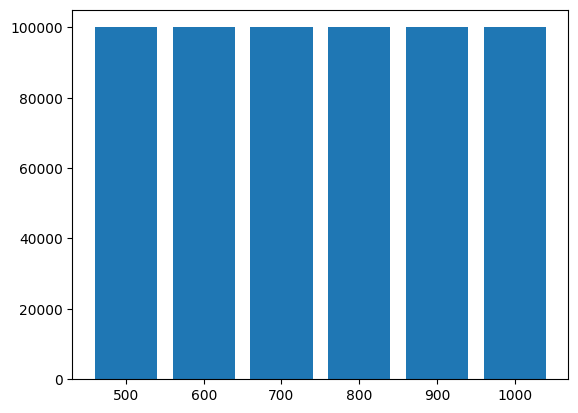

In [10]:
plt.hist(TrainingDF["Mass"], bins = len(Masses), range = [450, 1050], rwidth = 0.8)

(array([50000., 50000., 50000., 50000., 50000., 50000.]),
 array([ 450.,  550.,  650.,  750.,  850.,  950., 1050.]),
 <BarContainer object of 6 artists>)

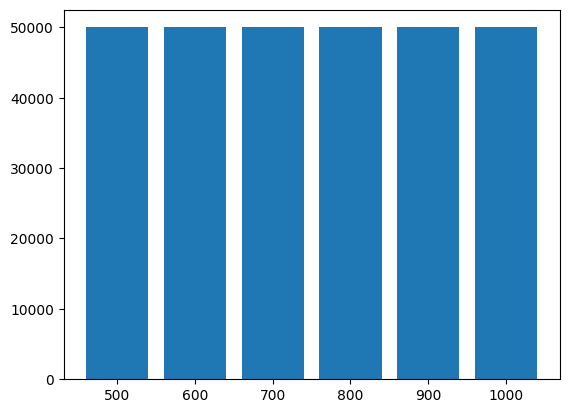

In [11]:
plt.hist(TestingDF["Mass"], bins = len(Masses), range = [450, 1050], rwidth = 0.8)

In [12]:
CNNinputs = []
for i in range(1,5):
    CNNinputs.append("pt_ordered_jet" + str(i) + "_pt")
    CNNinputs.append("pt_ordered_jet" + str(i) + "_eta")
    CNNinputs.append("pt_ordered_jet" + str(i) + "_phi")
    CNNinputs.append("pt_ordered_jet" + str(i) + "_m")
print (CNNinputs)

['pt_ordered_jet1_pt', 'pt_ordered_jet1_eta', 'pt_ordered_jet1_phi', 'pt_ordered_jet1_m', 'pt_ordered_jet2_pt', 'pt_ordered_jet2_eta', 'pt_ordered_jet2_phi', 'pt_ordered_jet2_m', 'pt_ordered_jet3_pt', 'pt_ordered_jet3_eta', 'pt_ordered_jet3_phi', 'pt_ordered_jet3_m', 'pt_ordered_jet4_pt', 'pt_ordered_jet4_eta', 'pt_ordered_jet4_phi', 'pt_ordered_jet4_m']


In [13]:
TrainingInputs_DNN = TrainingDF[["fourjetmasstev", "Mjj_msortedP1_high", "Mjj_msortedP1_low",
            "Mjj_msortedP2_high", "Mjj_msortedP2_low", "Mjj_msortedP3_high", "Mjj_msortedP3_low"]].to_numpy()
TrainingInputs_CNN = TrainingDF[CNNinputs].to_numpy()
TrainingTruth = TrainingDF["Truth_QSMD"].to_numpy()

TestingInputs_DNN = TestingDF[["fourjetmasstev", "Mjj_msortedP1_high", "Mjj_msortedP1_low",
            "Mjj_msortedP2_high", "Mjj_msortedP2_low", "Mjj_msortedP3_high", "Mjj_msortedP3_low"]].to_numpy()
TestingInputs_CNN = TestingDF[CNNinputs].to_numpy()

In [14]:
print(TrainingInputs_DNN.shape)
print(TrainingInputs_CNN.shape)
print(TrainingTruth.shape)

print(TestingInputs_DNN.shape)
print(TestingInputs_CNN.shape)

(600000, 7)
(600000, 16)
(600000,)
(300000, 7)
(300000, 16)


In [15]:
def model_CNN_test1():
    cnn_input  = tf.keras.Input(shape=(4*4, ), name="cnn_input")
    cnn_output = tf.keras.layers.Reshape((4,4, 1))(cnn_input)
    cnn_output = tf.keras.layers.Conv2D(32, (4,4), activation='relu') (cnn_output)
    cnn_output = tf.keras.layers.Flatten()(cnn_output)
    
    dnn_input  = tf.keras.Input(shape=(7, ), name="dnn_input")
    dnn_output = tf.keras.layers.concatenate([cnn_output, dnn_input])
    
    dnn_output = tf.keras.layers.Dense(128, activation='relu')(dnn_output)
    dnn_output = tf.keras.layers.Dense(32, activation='relu')(dnn_output)
    dnn_output = tf.keras.layers.Dense(8, activation='relu')(dnn_output)
    dnn_output = tf.keras.layers.Dense(3, activation='softmax', name="model_out")(dnn_output)

    Model = tf.keras.Model(inputs=[cnn_input, dnn_input], outputs=dnn_output)
    Model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
    return Model

In [16]:
#Model = model_DNN()
Model = model_CNN_test1()
Model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 cnn_input (InputLayer)         [(None, 16)]         0           []                               
                                                                                                  
 reshape (Reshape)              (None, 4, 4, 1)      0           ['cnn_input[0][0]']              
                                                                                                  
 conv2d (Conv2D)                (None, 1, 1, 32)     544         ['reshape[0][0]']                
                                                                                                  
 flatten (Flatten)              (None, 32)           0           ['conv2d[0][0]']                 
                                                                                              

2023-07-31 16:58:19.778694: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-31 16:58:20.624928: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3937 MB memory:  -> device: 0, name: Tesla P100-PCIE-12GB, pci bus id: 0000:65:00.0, compute capability: 6.0


In [17]:
Model.fit({"cnn_input": TrainingInputs_CNN, "dnn_input": TrainingInputs_DNN}, TrainingTruth, batch_size = 1024,
          epochs = 50, validation_split = 0.2)

Epoch 1/50


2023-07-31 16:58:22.097581: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


469/469 [==============================] - 4s 4ms/step - loss: 0.5674 - accuracy: 0.7538 - val_loss: 0.6621 - val_accuracy: 0.6939
Epoch 2/50
469/469 [==============================] - 1s 3ms/step - loss: 0.4261 - accuracy: 0.8193 - val_loss: 0.6767 - val_accuracy: 0.6809
Epoch 3/50
469/469 [==============================] - 1s 3ms/step - loss: 0.4096 - accuracy: 0.8248 - val_loss: 0.6504 - val_accuracy: 0.6935
Epoch 4/50
469/469 [==============================] - 1s 3ms/step - loss: 0.3985 - accuracy: 0.8270 - val_loss: 0.7065 - val_accuracy: 0.6723
Epoch 5/50
469/469 [==============================] - 1s 3ms/step - loss: 0.3921 - accuracy: 0.8290 - val_loss: 0.6501 - val_accuracy: 0.6961
Epoch 6/50
469/469 [==============================] - 1s 3ms/step - loss: 0.3867 - accuracy: 0.8303 - val_loss: 0.6515 - val_accuracy: 0.6965
Epoch 7/50
469/469 [==============================] - 1s 3ms/step - loss: 0.3831 - accuracy: 0.8312 - val_loss: 0.5998 - val_accuracy: 0.7242
Epoch 8/50
469/46

In [18]:
TestingOutputs = Model.predict({"cnn_input": TestingInputs_CNN, "dnn_input": TestingInputs_DNN}, batch_size = 1024)

293/293 [==============================] - 1s 1ms/step


In [19]:
TestingOutputs[0] #ML raw output is the probability of 3 sparse categories

array([1.1025659e-05, 9.8997575e-01, 1.0013291e-02], dtype=float32)

In [20]:
TestingPredictions = np.argmax(TestingOutputs, axis = 1) #pick the highest probability as ML output

In [21]:
print(TestingPredictions.shape)
print(TestingPredictions[0])

(300000,)
1


In [22]:
TestingDF["Pred"] = TestingPredictions.tolist()

In [23]:
TestingDF

,fourjetmasstev,Mjj_msortedP1_high_div4jm,Mjj_msortedP2_high_div4jm,Mjj_msortedP3_high_div4jm,Mjj_msortedP1_high,Mjj_msortedP1_low,Mjj_msortedP2_high,Mjj_msortedP2_low,Mjj_msortedP3_high,Mjj_msortedP3_low,Mjj_avg_dRpairing_GeV,pt_ordered_jet1_pt,pt_ordered_jet1_eta,pt_ordered_jet1_phi,pt_ordered_jet1_m,pt_ordered_jet2_pt,pt_ordered_jet2_eta,pt_ordered_jet2_phi,pt_ordered_jet2_m,pt_ordered_jet3_pt,pt_ordered_jet3_eta,pt_ordered_jet3_phi,pt_ordered_jet3_m,pt_ordered_jet4_pt,pt_ordered_jet4_eta,pt_ordered_jet4_phi,pt_ordered_jet4_m,evt_trig,Mass,P1M,P2M,P3M,dRi,Truth_high,Truth_avg,P1QSMD,P2QSMD,P3QSMD,Truth_QSMD,Pred
0,1.270563,0.592479,0.457237,0.444398,0.752781,0.148789,0.580948,0.488222,0.564636,0.379613,0.450785,0.445276,1.192871,0.220795,0.534018,0.396414,0.826538,-1.889648,0.376832,0.253830,1.022705,2.150391,0.440484,0.142262,1.403320,2.746094,0.205556,1,500,450.785098,534.585277,472.124324,0,2,2,1.872477e+05,6691.301795,18670.853182,1,1
1,1.475435,0.547174,0.491401,0.419803,0.807320,0.257938,0.725030,0.534675,0.619392,0.519556,0.532629,0.386220,0.712402,2.030273,0.261688,0.319353,0.188324,-1.345215,0.359117,0.221728,0.081406,-2.320312,0.237767,0.166014,-1.630371,0.653198,0.268445,1,500,532.628989,629.852393,569.474171,0,2,0,1.530393e+05,51840.770029,14636.941430,2,1
2,1.161358,0.610406,0.422835,0.371498,0.708900,0.431600,0.491063,0.435224,0.431442,0.229310,0.330376,0.385469,-1.280762,2.541504,0.437522,0.319098,-0.842651,-1.010498,0.381490,0.201867,-1.448730,0.814819,0.201651,0.200784,-0.624023,-1.872314,0.300211,1,500,570.249968,463.143578,330.376313,2,1,1,4.831779e+04,4275.799300,77973.026888,1,1
3,1.439718,0.678990,0.456938,0.339597,0.977554,0.303681,0.657862,0.573336,0.488924,0.177533,0.333229,0.499242,-0.684570,-0.824707,0.311871,0.468612,-0.261902,1.964355,0.440882,0.155829,-1.869385,2.106445,0.171488,0.134420,-1.299805,-1.028320,0.185082,1,500,640.617487,615.598976,333.228788,2,2,1,2.665987e+05,30298.488570,104107.347093,1,1
4,2.699749,0.675547,0.536849,0.452600,1.823807,0.253359,1.449358,0.442720,1.221906,0.411076,0.816491,1.287038,-0.572021,2.635254,1.159612,0.640474,-0.784302,-0.786865,1.126436,0.387331,-0.167114,-0.370422,0.575982,0.267378,0.160522,-1.045410,0.282222,1,500,1038.583151,946.039040,816.490894,2,2,2,1.813298e+06,904561.556151,529055.556753,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,1.166589,0.591774,0.576928,0.485911,0.690357,0.175872,0.673037,0.128909,0.566859,0.269989,0.400973,0.580431,-0.787231,-2.472656,0.617705,0.199628,-0.520996,0.828247,0.254577,0.141492,-1.962158,1.009766,0.146705,0.138341,-1.006348,0.296143,0.229745,1,1000,433.114600,400.973399,418.424179,1,0,0,7.750651e+05,865703.411694,720526.665996,2,2
299996,2.218874,0.525513,0.446088,0.309142,1.166048,0.902160,0.989812,0.930570,0.685946,0.667445,0.676696,0.673639,0.838867,-3.100098,0.445459,0.534680,1.001953,0.568726,0.400948,0.453578,0.952515,-0.905151,0.417009,0.272741,-0.549316,2.650879,0.244101,1,1000,1034.103896,960.191267,676.695534,2,1,0,3.714466e+04,4924.284517,209222.706016,1,2
299997,2.551666,0.608357,0.405521,0.399058,1.552324,0.859959,1.034753,0.920880,1.018263,0.652701,0.835482,0.487786,-1.555176,1.605713,0.678594,0.470927,0.623169,-2.262207,0.388364,0.423128,-0.494629,0.689331,0.307038,0.421724,-1.281250,-1.694824,0.535643,1,1000,1206.141640,977.816285,835.481783,2,2,1,3.246738e+05,7467.811432,120950.226865,1,2
299998,2.015078,0.613639,0.496935,0.240186,1.236529,0.651030,1.001363,0.853832,0.483993,0.392136,0.438065,0.562967,-0.582764,1.727783,0.364735,0.511767,0.548096,-1.800293,0.580245,0.443341,-0.395081,-1.592041,0.222607,0.281440,-0.571045,0.714600,0.291451,1,1000,943.779885,927.597488,438.064941,2,1,0,1.777259e+05,21366.912445,635760.867730,1,1


In [24]:
AccPred = []
AccdR = []
Acc0 = []
Acc1 = []
Acc2 = []
for Mass in Masses:
    TestingDF_temp = TestingDF.loc[TestingDF["Mass"] == Mass]
    TestingDF_pred = TestingDF_temp.loc[TestingDF_temp["Pred"]==TestingDF_temp["Truth_QSMD"]]
    TestingDF_dR = TestingDF_temp.loc[TestingDF_temp["dRi"]==TestingDF_temp["Truth_QSMD"]]
    TestingDF_0 = TestingDF_temp.loc[0==TestingDF_temp["Truth_QSMD"]]
    TestingDF_1 = TestingDF_temp.loc[1==TestingDF_temp["Truth_QSMD"]]
    TestingDF_2 = TestingDF_temp.loc[2==TestingDF_temp["Truth_QSMD"]]

    AccPred.append(float(len(TestingDF_pred.index))/len(TestingDF_temp.index))
    AccdR.append(float(len(TestingDF_dR.index))/len(TestingDF_temp.index))
    Acc0.append(float(len(TestingDF_0.index))/len(TestingDF_temp.index))
    Acc1.append(float(len(TestingDF_1.index))/len(TestingDF_temp.index))
    Acc2.append(float(len(TestingDF_2.index))/len(TestingDF_temp.index))

In [25]:
print(AccPred, "Average %.2f" % float(sum(AccPred)/len(AccPred)))
print(AccdR, "Average %.2f" % float(sum(AccdR)/len(AccdR)))
print(Acc0, "Average %.2f" % float(sum(Acc0)/len(Acc0)))
print(Acc1, "Average %.2f" % float(sum(Acc1)/len(Acc1)))
print(Acc2, "Average %.2f" % float(sum(Acc2)/len(Acc2)))

[0.7476, 0.86052, 0.88734, 0.8787, 0.80914, 0.6726] Average 0.81
[0.40518, 0.26074, 0.20318, 0.1743, 0.1593, 0.1449] Average 0.22
[0.04464, 0.10282, 0.1414, 0.1548, 0.16504, 0.1733] Average 0.13
[0.30308, 0.3993, 0.43246, 0.45576, 0.46728, 0.4764] Average 0.42
[0.65228, 0.49788, 0.42614, 0.38944, 0.36768, 0.3503] Average 0.45


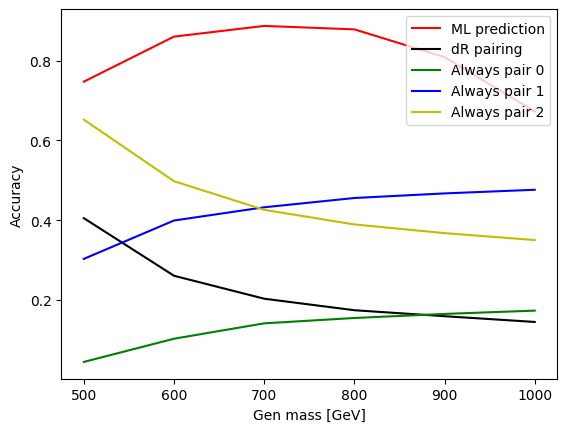

In [26]:
plt.plot(Masses, AccPred, "r", label = "ML prediction")
plt.plot(Masses, AccdR, "k", label = "dR pairing")
plt.plot(Masses, Acc0, "g", label = "Always pair 0")
plt.plot(Masses, Acc1, "b", label = "Always pair 1")
plt.plot(Masses, Acc2, "y", label = "Always pair 2")
plt.legend(loc="upper right")
plt.xlabel("Gen mass [GeV]")
plt.ylabel("Accuracy")
plt.savefig("plots/" + Model.name + "_Acc_vs_mass.png")

In [27]:
P1Mi = TestingDF.columns.get_loc("P1M")
#TestingDF["dR_M"] = TestingDF.apply(lambda row: row.iloc[row["dRi"]], axis=1)
TestingDF["dR_M"] = TestingDF.to_numpy()[np.arange(len(TestingDF)), P1Mi + TestingDF["dRi"]]
TestingDF["Truth_high_M"] = TestingDF.to_numpy()[np.arange(len(TestingDF)), P1Mi + TestingDF["Truth_high"]]
TestingDF["Truth_avg_M"] = TestingDF.to_numpy()[np.arange(len(TestingDF)), P1Mi + TestingDF["Truth_avg"]]
TestingDF["Pred_M"] = TestingDF.to_numpy()[np.arange(len(TestingDF)), P1Mi + TestingDF["Pred"]]
TestingDF

,fourjetmasstev,Mjj_msortedP1_high_div4jm,Mjj_msortedP2_high_div4jm,Mjj_msortedP3_high_div4jm,Mjj_msortedP1_high,Mjj_msortedP1_low,Mjj_msortedP2_high,Mjj_msortedP2_low,Mjj_msortedP3_high,Mjj_msortedP3_low,Mjj_avg_dRpairing_GeV,pt_ordered_jet1_pt,pt_ordered_jet1_eta,pt_ordered_jet1_phi,pt_ordered_jet1_m,pt_ordered_jet2_pt,pt_ordered_jet2_eta,pt_ordered_jet2_phi,pt_ordered_jet2_m,pt_ordered_jet3_pt,pt_ordered_jet3_eta,pt_ordered_jet3_phi,pt_ordered_jet3_m,pt_ordered_jet4_pt,pt_ordered_jet4_eta,pt_ordered_jet4_phi,pt_ordered_jet4_m,evt_trig,Mass,P1M,P2M,P3M,dRi,Truth_high,Truth_avg,P1QSMD,P2QSMD,P3QSMD,Truth_QSMD,Pred,dR_M,Truth_high_M,Truth_avg_M,Pred_M
0,1.270563,0.592479,0.457237,0.444398,0.752781,0.148789,0.580948,0.488222,0.564636,0.379613,0.450785,0.445276,1.192871,0.220795,0.534018,0.396414,0.826538,-1.889648,0.376832,0.253830,1.022705,2.150391,0.440484,0.142262,1.403320,2.746094,0.205556,1,500,450.785098,534.585277,472.124324,0,2,2,1.872477e+05,6691.301795,18670.853182,1,1,450.785098,472.124324,472.124324,534.585277
1,1.475435,0.547174,0.491401,0.419803,0.807320,0.257938,0.725030,0.534675,0.619392,0.519556,0.532629,0.386220,0.712402,2.030273,0.261688,0.319353,0.188324,-1.345215,0.359117,0.221728,0.081406,-2.320312,0.237767,0.166014,-1.630371,0.653198,0.268445,1,500,532.628989,629.852393,569.474171,0,2,0,1.530393e+05,51840.770029,14636.941430,2,1,532.628989,569.474171,532.628989,629.852393
2,1.161358,0.610406,0.422835,0.371498,0.708900,0.431600,0.491063,0.435224,0.431442,0.229310,0.330376,0.385469,-1.280762,2.541504,0.437522,0.319098,-0.842651,-1.010498,0.381490,0.201867,-1.448730,0.814819,0.201651,0.200784,-0.624023,-1.872314,0.300211,1,500,570.249968,463.143578,330.376313,2,1,1,4.831779e+04,4275.799300,77973.026888,1,1,330.376313,463.143578,463.143578,463.143578
3,1.439718,0.678990,0.456938,0.339597,0.977554,0.303681,0.657862,0.573336,0.488924,0.177533,0.333229,0.499242,-0.684570,-0.824707,0.311871,0.468612,-0.261902,1.964355,0.440882,0.155829,-1.869385,2.106445,0.171488,0.134420,-1.299805,-1.028320,0.185082,1,500,640.617487,615.598976,333.228788,2,2,1,2.665987e+05,30298.488570,104107.347093,1,1,333.228788,333.228788,615.598976,615.598976
4,2.699749,0.675547,0.536849,0.452600,1.823807,0.253359,1.449358,0.442720,1.221906,0.411076,0.816491,1.287038,-0.572021,2.635254,1.159612,0.640474,-0.784302,-0.786865,1.126436,0.387331,-0.167114,-0.370422,0.575982,0.267378,0.160522,-1.045410,0.282222,1,500,1038.583151,946.039040,816.490894,2,2,2,1.813298e+06,904561.556151,529055.556753,2,2,816.490894,816.490894,816.490894,816.490894
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,1.166589,0.591774,0.576928,0.485911,0.690357,0.175872,0.673037,0.128909,0.566859,0.269989,0.400973,0.580431,-0.787231,-2.472656,0.617705,0.199628,-0.520996,0.828247,0.254577,0.141492,-1.962158,1.009766,0.146705,0.138341,-1.006348,0.296143,0.229745,1,1000,433.114600,400.973399,418.424179,1,0,0,7.750651e+05,865703.411694,720526.665996,2,2,400.973399,433.114600,433.114600,418.424179
299996,2.218874,0.525513,0.446088,0.309142,1.166048,0.902160,0.989812,0.930570,0.685946,0.667445,0.676696,0.673639,0.838867,-3.100098,0.445459,0.534680,1.001953,0.568726,0.400948,0.453578,0.952515,-0.905151,0.417009,0.272741,-0.549316,2.650879,0.244101,1,1000,1034.103896,960.191267,676.695534,2,1,0,3.714466e+04,4924.284517,209222.706016,1,2,676.695534,960.191267,1034.103896,676.695534
299997,2.551666,0.608357,0.405521,0.399058,1.552324,0.859959,1.034753,0.920880,1.018263,0.652701,0.835482,0.487786,-1.555176,1.605713,0.678594,0.470927,0.623169,-2.262207,0.388364,0.423128,-0.494629,0.689331,0.307038,0.421724,-1.281250,-1.694824,0.535643,1,1000,1206.141640,977.816285,835.481783,2,2,1,3.246738e+05,7467.811432,120950.226865,1,2,835.481783,835.481783,977.816285,835.481783
299998,2.015078,0.613639,0.496935,0.240186,1.236529,0.651030,1.001363,0.853832,0.483

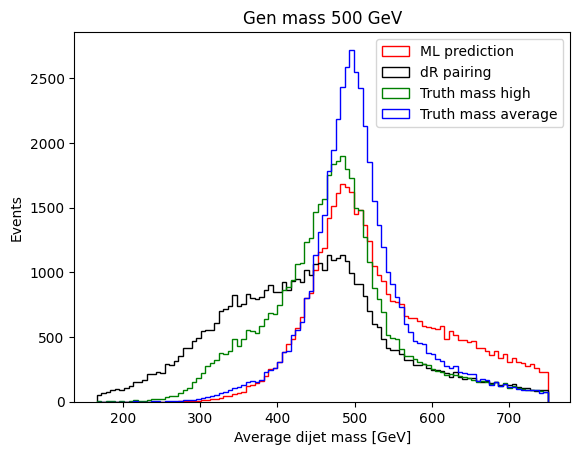

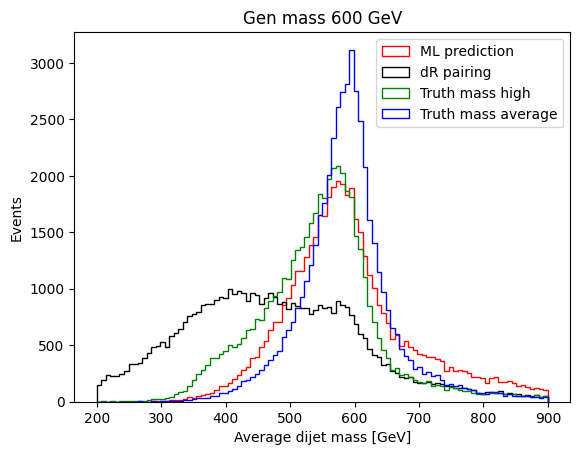

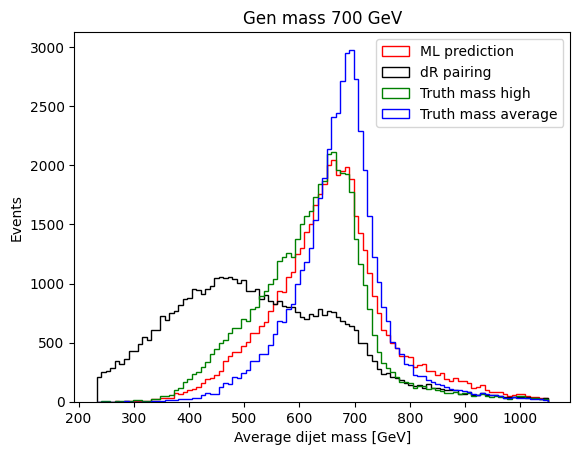

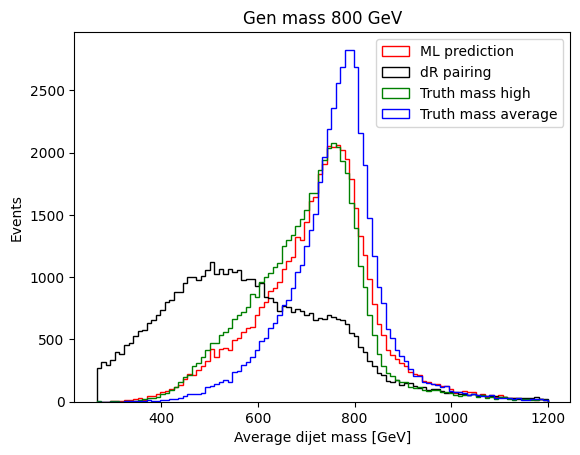

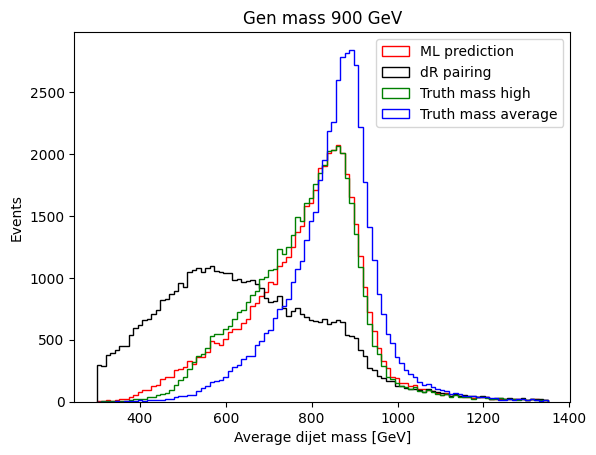

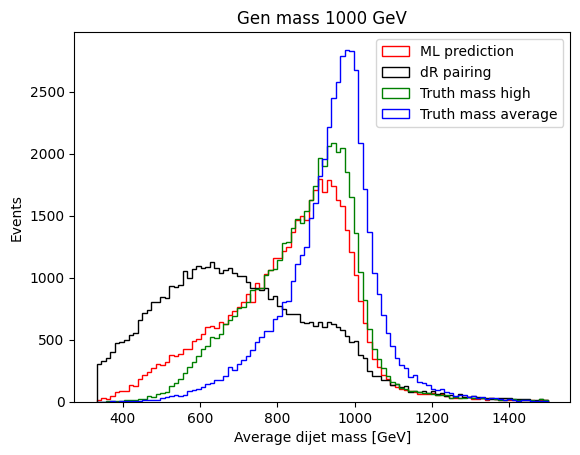

In [28]:
# for each gen mass sample, plot average dijet mass
for Mass in Masses:
    TestingDF_temp = TestingDF.loc[TestingDF["Mass"] == Mass]
    plt.figure()
    plt.hist(TestingDF_temp["Pred_M"], bins = 100, range = [Mass/3, Mass*1.5], histtype = "step", color = "r", label = "ML prediction")
    plt.hist(TestingDF_temp["dR_M"], bins = 100, range = [Mass/3, Mass*1.5], histtype = "step", color = "k", label = "dR pairing")
    plt.hist(TestingDF_temp["Truth_high_M"], bins = 100, range = [Mass/3, Mass*1.5], histtype = "step", color = "g", label = "Truth mass high")
    plt.hist(TestingDF_temp["Truth_avg_M"], bins = 100, range = [Mass/3, Mass*1.5], histtype = "step", color = "b", label = "Truth mass average")
    plt.legend(loc="upper right")
    plt.title("Gen mass " + str(Mass) + " GeV")
    plt.xlabel("Average dijet mass [GeV]")
    plt.ylabel("Events")
    plt.show()

In [29]:
P1QSMDi = TestingDF.columns.get_loc("P1QSMD")
TestingDF["dR_QSMD"] = TestingDF.to_numpy()[np.arange(len(TestingDF)), P1QSMDi + TestingDF["dRi"]]
TestingDF["Truth_high_QSMD"] = TestingDF.to_numpy()[np.arange(len(TestingDF)), P1QSMDi + TestingDF["Truth_high"]]
TestingDF["Truth_avg_QSMD"] = TestingDF.to_numpy()[np.arange(len(TestingDF)), P1QSMDi + TestingDF["Truth_avg"]]
TestingDF["Pred_QSMD"] = TestingDF.to_numpy()[np.arange(len(TestingDF)), P1QSMDi + TestingDF["Pred"]]
TestingDF

,fourjetmasstev,Mjj_msortedP1_high_div4jm,Mjj_msortedP2_high_div4jm,Mjj_msortedP3_high_div4jm,Mjj_msortedP1_high,Mjj_msortedP1_low,Mjj_msortedP2_high,Mjj_msortedP2_low,Mjj_msortedP3_high,Mjj_msortedP3_low,Mjj_avg_dRpairing_GeV,pt_ordered_jet1_pt,pt_ordered_jet1_eta,pt_ordered_jet1_phi,pt_ordered_jet1_m,pt_ordered_jet2_pt,pt_ordered_jet2_eta,pt_ordered_jet2_phi,pt_ordered_jet2_m,pt_ordered_jet3_pt,pt_ordered_jet3_eta,pt_ordered_jet3_phi,pt_ordered_jet3_m,pt_ordered_jet4_pt,pt_ordered_jet4_eta,pt_ordered_jet4_phi,pt_ordered_jet4_m,evt_trig,Mass,P1M,P2M,P3M,dRi,Truth_high,Truth_avg,P1QSMD,P2QSMD,P3QSMD,Truth_QSMD,Pred,dR_M,Truth_high_M,Truth_avg_M,Pred_M,dR_QSMD,Truth_high_QSMD,Truth_avg_QSMD,Pred_QSMD
0,1.270563,0.592479,0.457237,0.444398,0.752781,0.148789,0.580948,0.488222,0.564636,0.379613,0.450785,0.445276,1.192871,0.220795,0.534018,0.396414,0.826538,-1.889648,0.376832,0.253830,1.022705,2.150391,0.440484,0.142262,1.403320,2.746094,0.205556,1,500,450.785098,534.585277,472.124324,0,2,2,1.872477e+05,6691.301795,18670.853182,1,1,450.785098,472.124324,472.124324,534.585277,187247.684022,18670.853182,18670.853182,6691.301795
1,1.475435,0.547174,0.491401,0.419803,0.807320,0.257938,0.725030,0.534675,0.619392,0.519556,0.532629,0.386220,0.712402,2.030273,0.261688,0.319353,0.188324,-1.345215,0.359117,0.221728,0.081406,-2.320312,0.237767,0.166014,-1.630371,0.653198,0.268445,1,500,532.628989,629.852393,569.474171,0,2,0,1.530393e+05,51840.770029,14636.941430,2,1,532.628989,569.474171,532.628989,629.852393,153039.326089,14636.941430,153039.326089,51840.770029
2,1.161358,0.610406,0.422835,0.371498,0.708900,0.431600,0.491063,0.435224,0.431442,0.229310,0.330376,0.385469,-1.280762,2.541504,0.437522,0.319098,-0.842651,-1.010498,0.381490,0.201867,-1.448730,0.814819,0.201651,0.200784,-0.624023,-1.872314,0.300211,1,500,570.249968,463.143578,330.376313,2,1,1,4.831779e+04,4275.799300,77973.026888,1,1,330.376313,463.143578,463.143578,463.143578,77973.026888,4275.799300,4275.799300,4275.799300
3,1.439718,0.678990,0.456938,0.339597,0.977554,0.303681,0.657862,0.573336,0.488924,0.177533,0.333229,0.499242,-0.684570,-0.824707,0.311871,0.468612,-0.261902,1.964355,0.440882,0.155829,-1.869385,2.106445,0.171488,0.134420,-1.299805,-1.028320,0.185082,1,500,640.617487,615.598976,333.228788,2,2,1,2.665987e+05,30298.488570,104107.347093,1,1,333.228788,333.228788,615.598976,615.598976,104107.347093,104107.347093,30298.488570,30298.488570
4,2.699749,0.675547,0.536849,0.452600,1.823807,0.253359,1.449358,0.442720,1.221906,0.411076,0.816491,1.287038,-0.572021,2.635254,1.159612,0.640474,-0.784302,-0.786865,1.126436,0.387331,-0.167114,-0.370422,0.575982,0.267378,0.160522,-1.045410,0.282222,1,500,1038.583151,946.039040,816.490894,2,2,2,1.813298e+06,904561.556151,529055.556753,2,2,816.490894,816.490894,816.490894,816.490894,529055.556753,529055.556753,529055.556753,529055.556753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,1.166589,0.591774,0.576928,0.485911,0.690357,0.175872,0.673037,0.128909,0.566859,0.269989,0.400973,0.580431,-0.787231,-2.472656,0.617705,0.199628,-0.520996,0.828247,0.254577,0.141492,-1.962158,1.009766,0.146705,0.138341,-1.006348,0.296143,0.229745,1,1000,433.114600,400.973399,418.424179,1,0,0,7.750651e+05,865703.411694,720526.665996,2,2,400.973399,433.114600,433.114600,418.424179,865703.411694,775065.141390,775065.141390,720526.665996
299996,2.218874,0.525513,0.446088,0.309142,1.166048,0.902160,0.989812,0.930570,0.685946,0.667445,0.676696,0.673639,0.838867,-3.100098,0.445459,0.534680,1.001953,0.568726,0.400948,0.453578,0.952515,-0.905151,0.417009,0.272741,-0.549316,2.650879,0.244101,1,1000,1034.103896,960.191267,676.695534,2,1,0,3.714466e+04,4924.284517,209222.706016,1,2,676.695534,960.191267,1034.103896,676.695534,209222.706016,4924.284517,37144.661243,209222.706016
299997,2.551666,0.608357,0.405521,

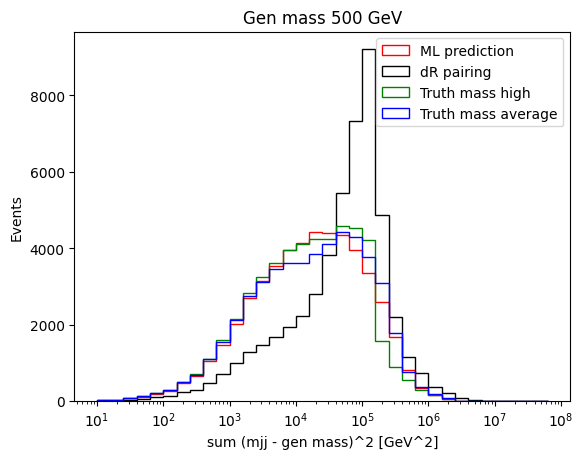

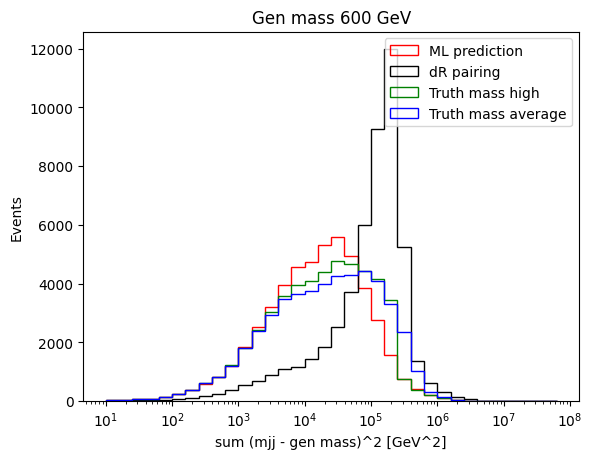

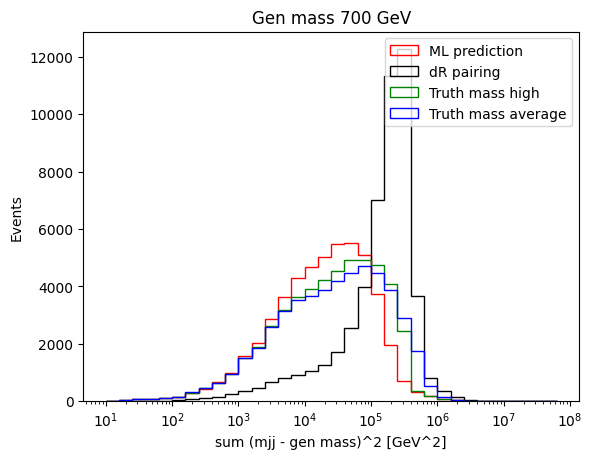

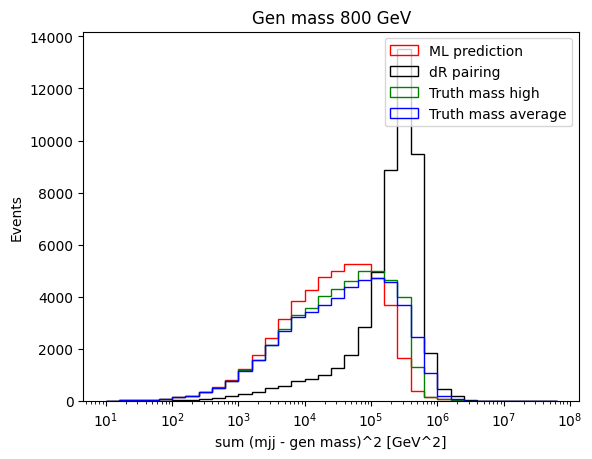

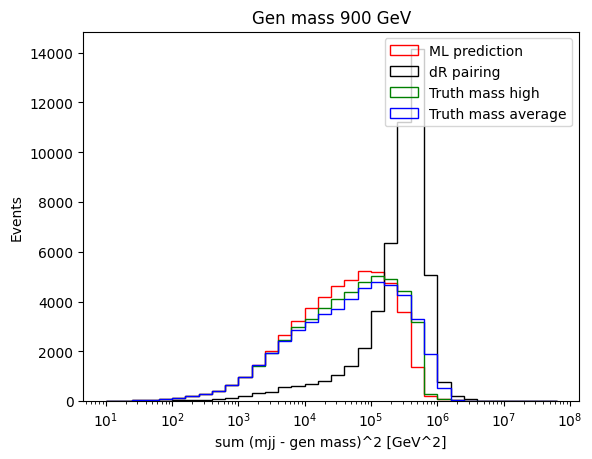

In [ ]:
# for each gen mass sample, plot dijet mass high
for Mass in Masses:
    TestingDF_temp = TestingDF.loc[TestingDF["Mass"] == Mass]
    Bins = [10**(x/5) for x in range(5,40)]
    plt.figure()
    plt.hist(TestingDF_temp["Pred_QSMD"], bins = Bins, histtype = "step", color = "r", label = "ML prediction")
    plt.hist(TestingDF_temp["dR_QSMD"], bins = Bins, histtype = "step", color = "k", label = "dR pairing")
    plt.hist(TestingDF_temp["Truth_high_QSMD"], bins = Bins, histtype = "step", color = "g", label = "Truth mass high")
    plt.hist(TestingDF_temp["Truth_avg_QSMD"], bins = Bins, histtype = "step", color = "b", label = "Truth mass average")
    plt.xscale('log')
    plt.legend(loc="upper right")
    plt.title("Gen mass " + str(Mass) + " GeV")
    plt.xlabel("sum (mjj - gen mass)^2 [GeV^2]")
    plt.ylabel("Events")
    plt.show()